# Beat Detection

This notebook contains my beat detection algorithm, and is better at showing the visualisations for a single file than calling the python function.

Simply run the cells in order and specify which file / directory you want to use to track the beats in the 'Testing One File' section.

F-scores can be calculated if the corresponding .beats file (from https://github.com/CPJKU/BallroomAnnotations) is placed in the same directory as the .wav file you want to analyze.

In [2]:
import os
import numpy as np
import librosa
from matplotlib import pyplot as plt
import IPython.display as ipd
from random import randrange
import math
import mir_eval
import random

# Onset Detection

In [3]:
def onsetFunctions(inFile, numOdfs, start = 0, hopTime = 0.010, fftTime = 0.040):
    """Calculate onset detection functions with input parameters:
         inFile (string): name of input audio file to analyse
         numOdfs (int): The number of odfs to compute
         start: start time (in seconds) for processing audio
         duration: duration (in seconds) of audio to process
         hopTime: hop size (in seconds) (time between successive frames)
         fftTime: length of frame to process (in seconds) - the given value is
                  rounded up to the next power of 2 (in samples)
      and return value (odf):
         a matrix of onset detection function results, with one row for each"""

    snd, rate = librosa.load(os.path.join(inFile),
                            offset=start, sr=None)
    hop = round(rate * hopTime)
    # round up to next power of 2
    len1 = int(2 ** np.ceil(np.log2(rate * fftTime)))
    len2 = int(len1/2)
    # centre first frame at t=0
    snd = np.concatenate([np.zeros(len2), snd, np.zeros(len2)])
    frameCount = int(np.floor((len(snd) - len1) / hop + 1))
    prevM = np.zeros(len1)
    prevA = np.zeros(len1)
    prevprevA = np.zeros(len1)
    odf = np.zeros((frameCount, numOdfs))
    for i in range(frameCount):
        start = i * hop
        currentFrame = np.fft.fft(np.multiply(snd[start: start+len1],
                                            np.hamming(len1)))
        mag = np.abs(currentFrame)
        rms = np.sqrt(np.mean(np.power(mag, 2)))
        hfc = np.mean(np.multiply(np.power(mag, 2),
                                list(range(len2)) + list(range(len2,0,-1))))
        sf = np.mean(np.multiply(np.greater(mag, prevM), np.subtract(mag, prevM)))
        phase = np.angle(currentFrame)
        tPhase = np.subtract(np.multiply(prevA, 2), prevprevA)
        cdVector = np.sqrt(np.subtract(np.add(np.power(prevM,2), np.power(mag,2)),
                            np.multiply(np.multiply(np.multiply(prevM, mag), 2),
                                        np.cos(np.subtract(phase, tPhase)))))
        rcd = np.mean(np.multiply(np.greater_equal(mag, prevM), cdVector))
        pdVector = np.abs(np.divide(np.subtract(np.mod(np.add(
                 np.subtract(phase, tPhase), np.pi), 2 * np.pi), np.pi), np.pi))
        if rms != 0:
            wpd = np.divide(np.mean(np.multiply(pdVector, mag)), rms * 2)
        else:
            wpd = 0
        if (numOdfs == 7):
            odf[i,:] = [rms, hfc, sf, np.mean(cdVector), rcd, np.mean(pdVector), wpd]
        elif (numOdfs == 2):
            odf[i,:] = [sf, rcd]
        else:
            odf[i] = sf
        prevprevA = prevA
        prevM = mag
        prevA = phase
    return odf

def medfilt(x, k):
    """Apply a length-k median filter to a 1D array x.
    Boundaries are extended by repeating endpoints.
    """
    if x.ndim > 1: # Input must be one-dimensional."
        y = [] 
        xt = np.transpose(x)
        for i in xt:
            y.append(medfilt(i, k))
        return np.transpose(y)
    k2 = (k - 1) // 2
    y = np.zeros((len(x), k), dtype=x.dtype)
    y[:,k2] = x
    for i in range(k2):
        j = k2 - i
        y[j:,i] = x[:-j]
        y[:j,i] = x[0]
        y[:-j,-(i+1)] = x[j:]
        y[-j:,-(i+1)] = x[-1]
    return np.median(y, axis=1)

def getOnsetsForOneFile(fileName, numOfODFs=2, plot=True):
    """Computes ODFs for a .wav file 
        fileName (String): path of .wav file
        numOfODFs (int): The number of ODFs to compute
        plot (Bool): Whether or not to plot the ODFs and onsets.
        
        return value (array of onsets): the times at which onsets occur
        (at 10ms resolution. i.e. a value of 1 corresponds to 10ms)"""
    thresh=1.25
    hop_time = 0.01
    odf = onsetFunctions(fileName, numOfODFs, hopTime=hop_time, fftTime=0.04)
    # normalise with median filtered sig
    odf = np.divide(odf+1, medfilt(odf+1, 9))
    # Why do we get NaN's after this np.divide?? I can't work it out.
    odf[np.isnan(odf)]=0
    
    # standardise to zero mean, unit stdev
    odf = np.divide(np.subtract(odf, np.mean(odf)), np.std(odf))
    odf[np.isnan(odf)]=0
    
    t = np.multiply(range(len(odf)), hop_time) #Resolution is 10ms.
    d = np.diff(odf, axis=0)
    isPeak = np.multiply(np.multiply(np.greater(odf, thresh),
                np.greater(np.concatenate([np.zeros((1,numOfODFs)), d]), 0)),
                np.less(np.concatenate([d, np.zeros((1,numOfODFs))]), 0))
    peaks = np.nonzero(isPeak) #peaks is a tuple of arrays. First array is where the peaks are. Second is which odf.
    peakIndex = peaks[0]
    odfNum = peaks[1]
    if plot:
        peakTimes=t[peakIndex]
        plt.figure(figsize=(20, 10))
        from cycler import cycler
        c = 'bgrcmyk'
        plt.rcParams['axes.prop_cycle'] = cycler(color=c)
        plt.plot(t, odf)
        legend = ['rms', 'hfc', 'sf ', 'cd ', 'rcd', 'pd ', 'wpd']
        for i in range(len(peaks[0])):
            plt.plot(peakTimes[i], odf[peaks[0][i], odfNum[i]],
                  'o' + c[odfNum[i]], label=legend[odfNum[i]])
        plt.title('Onsets found for file: ')
        plt.xlabel('Time')
        plt.ylabel('ODF')
    
    return peakIndex

# Clustering algorithm using onsets/IOIs.

In [4]:
class Cluster:
    """Class to represent a cluster of IOIs."""
    def __init__(self, IOIs):
        """ Initiate with a list of IOIs"""
        self.IOIs = IOIs
        self.size = len(self.IOIs)
        self.interval = np.mean(self.IOIs)
        self.score = 0
    
    def add_IOIs(self, IOIs):
        """ Add IOIs to it's list and recomputes the length and interval."""
        self.IOIs = self.IOIs + IOIs
        self.size = len(self.IOIs)
        self.interval = np.mean(self.IOIs)

def scoreFor(d):
    """Cluster scoring function for integer (d) multiples of other clusters' intervals."""
    assert(type(d) == int)
    if d >= 1 and d <= 4:
        return 6-d
    elif d >= 5 and d <= 8:
        return 1
    else:
        return 0

def calculateClusters(onsets, clusterWidth=3, plot=False, lowThreshold=10, highThreshold=150):
    """ The clustering algorithm.
    1. Find all possible IOIs within a defined period (lowThreshold<IOI<highThreshold).
    2. Find clusters of all the IOIs.
    3. Give clusters scores based on their weight and how many other clusters divide into them.
    
    Returns: a list of tuples of the form: (Cluster interval, Cluster score)"""
    
    clusters = []

    for onset_1 in onsets:
        for onset_2 in onsets:
            IOI = onset_2 - onset_1
            added = False
            if IOI >= lowThreshold and IOI <= highThreshold:
                #IOIs should be greater than 100msec or less than 1500msec
                for cluster in clusters:
                    if added == False and np.abs(cluster.interval - IOI) < clusterWidth:
                        cluster.add_IOIs([IOI])
                        added = True
                if added == False:
                    clusters = clusters + [Cluster([IOI])]
    #Join clusters that have similar intervals.
    for cluster_1 in clusters:
        for cluster_2 in clusters:
            if cluster_1 != cluster_2:
                if np.abs(cluster_1.interval - cluster_2.interval) < clusterWidth:
                    cluster_1.add_IOIs(cluster_2.IOIs)
                    clusters.remove(cluster_2)
    
    #Score clusters based on its interval relative to other clusters' intervals.
    maxClusterScore = 0
    for cluster_1 in clusters:
        for cluster_2 in clusters:
            if cluster_1 != cluster_2:
                for n in range(8):
                    if np.abs(cluster_1.interval - n*cluster_2.interval) < clusterWidth:
                        cluster_1.score += scoreFor(n)*cluster_2.size
        if cluster_1.score > maxClusterScore:
            maxClusterScore = cluster_1.score
    
    #Normalise the cluster scores to between 0 and 1.
    for cluster in clusters:
        cluster.score = cluster.score/maxClusterScore
    
    #Return two lists: (cluster IOIs, cluster scores)
    clusterIntervals = []
    clusterScores = []
    for cluster in clusters:
        clusterIntervals = clusterIntervals + [cluster.interval]
        clusterScores = clusterScores + [cluster.score]
    
    #A sorted list of tuples of all the clusters - (IOI, score)
    sortedClusters = sorted(list(zip(clusterIntervals, clusterScores)), key=lambda tup: tup[0])

    if plot:
        plt.figure(figsize=(14,4))
        plt.title('Cluster scores vs IOI')
        plt.xlabel('Cluster Interval (ms)')
        plt.ylabel('Cluster scores')
        for cluster in sortedClusters:
            plt.bar(cluster[0]*10, cluster[1], color='b', width = 10)
        plt.savefig('Clusters')
    return sortedClusters

# Multi-Agent Beat Tracking

In [5]:
class Agent():
    def __init__(self, _period, _onsetTime, _alpha, _clusterScore):
        self.period = _period
        self.onsetTime = _onsetTime
        self.alpha = _alpha
        self.mostRecentBeatTime = _onsetTime
        self.beatTimes = [_onsetTime]
        self.error = 0
        self.notFinished = True
        self.missedBeats = 0
        self.totalMissedBeats = 0
        self.hits = 0
        self.gotLost = False
        self.clusterScore = _clusterScore
    
    def predict(self):
        predictedBeat = self.mostRecentBeatTime + self.period
        return predictedBeat
    
    def updateHit(self, _nextBeat):
        #If the agent has become too fast (quicker than 150ms), then stop it.
        if _nextBeat - self.mostRecentBeatTime < 15:
            self.notFinished = False
            self.gotLost = True
        self.beatTimes = self.beatTimes + [_nextBeat]
        self.mostRecentBeatTime = _nextBeat
        self.missedBeats = 0
        self.hits = self.hits + 1
    
    def updateSemiHit(self, _nextBeat, _error):
        diff = _nextBeat - self.mostRecentBeatTime
        self.beatTimes = self.beatTimes + [_nextBeat]
        self.mostRecentBeatTime = _nextBeat
        self.period = self.alpha*diff + (1-self.alpha)*self.period
        self.error += (_error*_error)
        self.missedBeats = 0
        self.hits = self.hits + 1
    
    def updateMissedBeat(self):
        self.missedBeats = self.missedBeats+1
        self.totalMissedBeats = self.totalMissedBeats+1
        if self.missedBeats >= 4:
            self.notFinished = False
            self.gotLost = True
        predictedBeat = self.predict()
        self.mostRecentBeatTime = predictedBeat
        self.beatTimes = self.beatTimes + [predictedBeat]
    
    def getAveragePeriod(self):
        return (self.beatTimes[-1:]-self.beatTimes[0])/len(self.beatTimes)
        
    def getScore(self, scoreMatrix):
        if self.hits == 0:
            return -999
        if self.gotLost:
            return -999
        return scoreMatrix[0]*np.log(1+self.hits)-scoreMatrix[1]*np.log(1+self.totalMissedBeats)+scoreMatrix[2]*self.clusterScore-scoreMatrix[3]*((self.error)/self.hits)
    

def findClosestOnset(uniqueOnsets, predictedBeatTime):
    #Subtract the predicted beat time. The minimum absolute value of the difference is the closest onset.
    difference = np.subtract(uniqueOnsets, predictedBeatTime)
    absDifference = np.abs(difference)
    return uniqueOnsets[np.argmin(absDifference)]


def letAgentsLoose(clusters, numberOfStartingOnsets, uniqueOnsets,
                   alpha, innerErrorThreshold, outerErrorThreshold):
    """Algorithm that creates a series of agents that track the beat over time.
        clusters (list of tuples: [(ClusterIOI, ClusterScore)]): The clusters that have been found.
        numberOfStartingOnsets (int): How many onsets we consider as possible start of an agent's beat
        uniqueOnsets: list of unique onsets found by onset detection
        alpha (0-1): determines an agent's momentum vs reactiveness to beats that don't match up exactly with it's prediction
        innerErrorThreshold: The window either side of an agents prediction that it will accept
                                an onset as part of the beat
        outerErrorThreshold: The outer window either side of an agents prediction where an onset will affect
                                the agent's period."""

    agents = []
    startingOnsets = uniqueOnsets[0:numberOfStartingOnsets]
    for i,onset in enumerate(startingOnsets):
        #Create an agent for each cluster for each onset.
        for cluster in clusters:
            period = cluster[0]
            clusterScore = cluster[1]
            agents = agents + [Agent(period, onset, alpha, clusterScore)]
    
    for t in range(150): #150 is enough time steps assuming a 300bpm maximum for 30s clips
        for agent in agents:
            if agent.notFinished:
                predictedBeatTime = agent.predict()
                closestOnset = findClosestOnset(uniqueOnsets, predictedBeatTime)
                #If the agent has reached the end then we don't want to carry on predicting for it
                if closestOnset == uniqueOnsets[len(uniqueOnsets)-1]:
                    agent.notFinished = False
                if agent.notFinished:
                    #Error between agent's prediction and closest onset
                    error = np.abs(closestOnset-predictedBeatTime)
                    if error < innerErrorThreshold:
                        #Move the agent forward one step.
                        agent.updateHit(closestOnset)
                    elif error < outerErrorThreshold:
                        #agent's period will update slightly based on this onset.
                        agent.updateSemiHit(closestOnset, error)
                    else:
                        #Charge forth anyways with a missed beat.
                        agent.updateMissedBeat()
    return agents

def getBestAgentAndPrintBestAgentsScores(numberOfAgents, agents, scoreMatrix, plot=False):
    """Used when testing one file to quickly see how the best agents are performing."""
    bestPerformingAgent = -1
    
    if plot:
        plt.figure(figsize=(14,4))
        plt.title('Agent scores')
        plt.xlabel('Average Agent Interval (ms)')
        plt.ylabel('Agent Score')
        plt.ylim((-100, 100))
        for agent in agents:
            plt.bar(agent.getAveragePeriod()*10, agent.getScore(scoreMatrix), color='b', width=2)
        plt.savefig('AgentScores')
    
    for i in range(numberOfAgents):
        bestAgent = getBestAgent(agents, scoreMatrix)
        if i==0:
            bestPerformingAgent=bestAgent
        agents.remove(bestAgent)
        print('Period:', "{:.0f}".format(bestAgent.period*10), 'ms Error:', "{:.3f}".format(bestAgent.error), 
          'Missed Beats:', "{:d}".format(bestAgent.totalMissedBeats), 'Hit Beats:', "{:d}".format(bestAgent.hits),
         'Score:', "{:.3f}".format(bestAgent.getScore(scoreMatrix)), 'Cluster Score:', "{:.3f}".format(bestAgent.clusterScore))
    return bestPerformingAgent

def getBestAgent(agents, scoreMatrix):
    """Look through all the agents and find the one that scored best.
        agents (list of agents)
        scoreMatrix ([a, b, c, d]): list of scoring weightings for each possible scoring items within an agents
                                    getScore() method."""
    bestAgent = -1
    bestScore = -99999999999999
    for agent in agents:
        if (agent.getScore(scoreMatrix) > bestScore):
            bestScore = agent.getScore(scoreMatrix)
            bestAgent = agent
    return bestAgent

# Testing

In [6]:
def addCowbellAndPlot(fileName, bestAgent):
    """ Add a cowbell sound to the file on the beat times of the best agent.
        fileName (string): path of audio file
        bestAgent (Agent): the agent which performed best in the beat tracking algorithm."""
    cowbellSound = librosa.load(os.path.join('data/Cowbell.wav'))
    plt.figure(figsize=(14,3))
    plt.title('Waveform and beats found for ' + fileName + '\nBPM: ' + "{:.1f}".format(60/(bestAgent.period/100)))
    music, rate = librosa.load(os.path.join(fileName))
    cowbellSound, cbRate = librosa.load(os.path.join('data/Cowbell.wav'))
    t = np.arange(len(music))/rate
    plt.plot(t, music)
    
    for onset in bestAgent.beatTimes:
        plt.vlines(onset/100, -2, 2, color='k')
        if int(onset*rate/100)+len(cowbellSound) < len(music):
            #Add the cowbell sound if there's space in the file.
            music[int(onset*rate/100):int(onset*rate/100)+len(cowbellSound)] = music[int(onset*rate/100):int(onset*rate/100)+len(cowbellSound)] + cowbellSound
    
    plt.savefig('CowbellAdded')
    
    ipd.display(ipd.Audio(music,rate=rate))
    
def getAnnotationsFromFile(annotationsFile):
    """Returns a np array of beat times."""
    assert (annotationsFile[-6:] == '.beats'), ("Trying to get beat annotations from a file that's not .beats")
    
    f = open(annotationsFile, 'r')
    contents = f.read()
    annotations = []
    for line in contents.split('\n'):
        lineList = line.split()
        if len(lineList)>0:
            annotations += [float(lineList[0])]
    f.close()
    return annotations

# Testing One File

Run the cell below, and in the one after, specify which file you want to analyse.

In [7]:
def TestOneFile(fileName, numOfODFs=2, clusterWidth=3, alpha=0.15, innerErrorThreshold=4, outerErrorThreshold=6):
    """Test beat detection on one file, printing and plotting useful diagnostics."""
    snd, rate = librosa.load(fileName)
    plt.figure(figsize=(14,3))
    plt.plot(snd)
    
    peaksForOneFile = getOnsetsForOneFile(fileName, numOfODFs, plot=True)
    print('Number of onsets found:', len(peaksForOneFile))
    clusters = calculateClusters(peaksForOneFile, clusterWidth, plot=True)
    
    #Find the ordered set of onset times. Necessary when multiple ODFs used.
    uniqueOnsets = sorted(set(peaksForOneFile))
    
    numberOfStartingOnsets = 15 #Number of agents is numberOfStartingOnsets x numberOfClusters
    
    agents = letAgentsLoose(clusters, numberOfStartingOnsets, uniqueOnsets,
                            alpha, innerErrorThreshold, outerErrorThreshold)
    
    #Variables that determine an agent's score
    gHitScore      = 10
    gMissScore     = 3
    gSalienceScore = 5
    gErrorScore    = 0.01
    scoreMatrix = [gHitScore, gMissScore, gSalienceScore, gErrorScore]
    
    print("Best 5 agents and their scores:")
    bestAgent = getBestAgentAndPrintBestAgentsScores(5, agents.copy(), scoreMatrix, plot=True)
    bestAgentBeatTimes = np.zeros(len(bestAgent.beatTimes))
    for i,beat in enumerate(bestAgent.beatTimes):
        #Beat times are 10ms resolution, so divide by 100.
        bestAgentBeatTimes[i] = beat/100
    addCowbellAndPlot(fileName, bestAgent)
    
    #If you don't have the .beats files, you can remove the rest of the code from this cell.
    #Ground truth.
    annotations = np.array(getAnnotationsFromFile(fileName[:-4] + '.beats'))
    
    annotations = mir_eval.beat.trim_beats(annotations, min_beat_time=5.0)
    bestAgentBeatTimes = mir_eval.beat.trim_beats(bestAgentBeatTimes, min_beat_time=5.0)
    f_measure = mir_eval.beat.f_measure(annotations, bestAgentBeatTimes, f_measure_threshold=0.1)
    CMLc, CMLt, AMLc, AMLt = mir_eval.beat.continuity(annotations, bestAgentBeatTimes)
    print('F-measure', f_measure, '\n')
    print('Accuracy at any level', AMLt, '\n')
    

Number of onsets found: 144
Period: 938 ms Error: 115.634 Missed Beats: 4 Hit Beats: 25 Score: 31.547 Cluster Score: 0.768
Period: 938 ms Error: 115.634 Missed Beats: 4 Hit Beats: 24 Score: 31.153 Cluster Score: 0.768
Period: 938 ms Error: 115.634 Missed Beats: 4 Hit Beats: 23 Score: 30.743 Cluster Score: 0.768
Period: 938 ms Error: 115.634 Missed Beats: 4 Hit Beats: 22 Score: 30.315 Cluster Score: 0.768
Period: 942 ms Error: 109.304 Missed Beats: 5 Hit Beats: 22 Score: 29.771 Cluster Score: 0.768
Period: 707 ms Error: 154.633 Missed Beats: 10 Hit Beats: 27 Score: 29.767 Cluster Score: 0.739
Period: 706 ms Error: 104.962 Missed Beats: 10 Hit Beats: 26 Score: 29.420 Cluster Score: 0.739
Period: 706 ms Error: 104.962 Missed Beats: 10 Hit Beats: 26 Score: 29.420 Cluster Score: 0.739
Period: 942 ms Error: 109.304 Missed Beats: 5 Hit Beats: 21 Score: 29.324 Cluster Score: 0.768
Period: 706 ms Error: 104.962 Missed Beats: 10 Hit Beats: 25 Score: 29.041 Cluster Score: 0.739


F-measure 0.6329113924050632 

Accuracy at any level 0.9259259259259259 



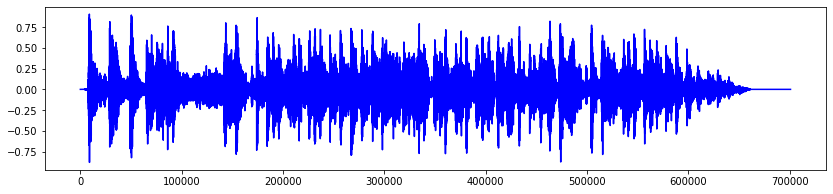

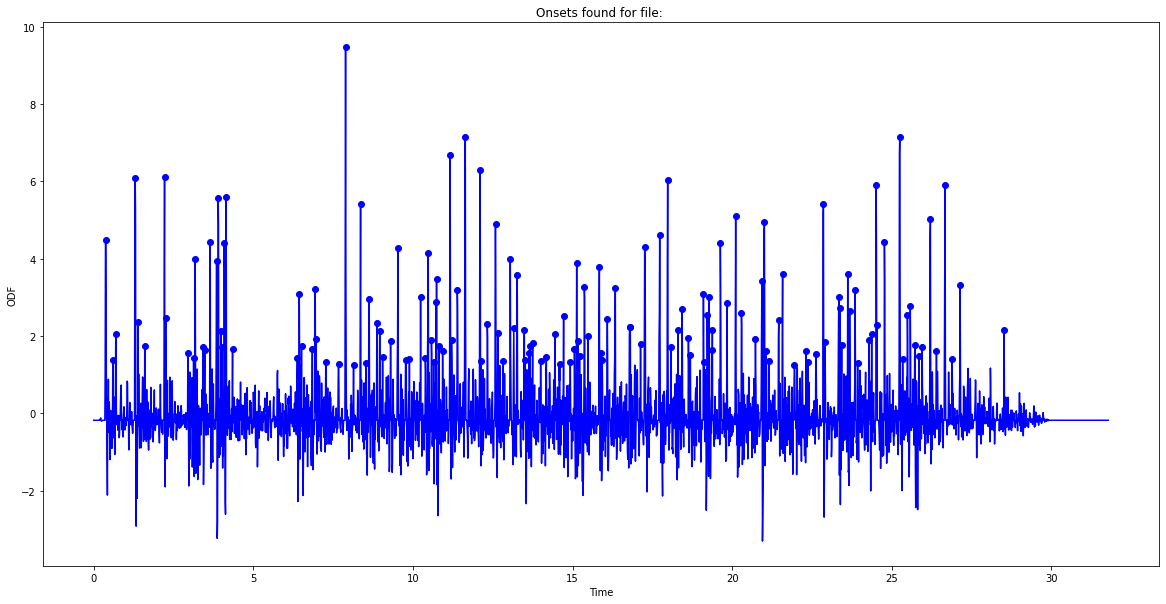

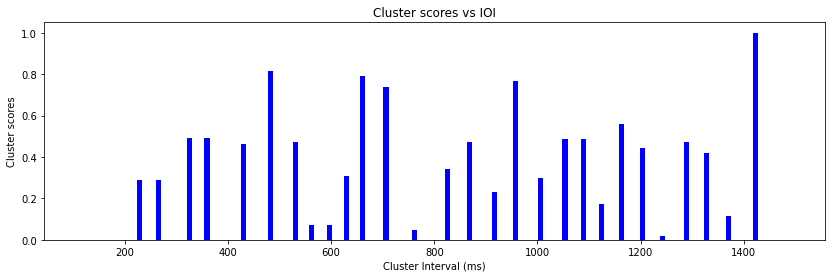

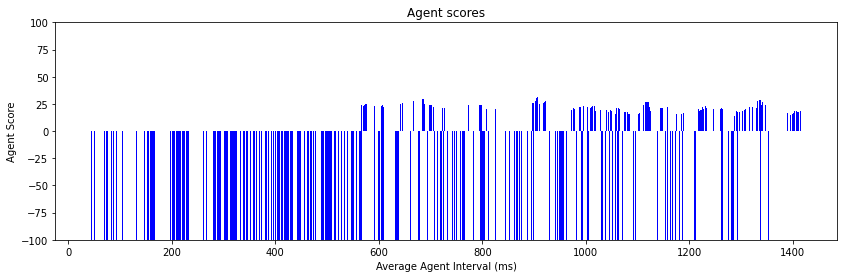

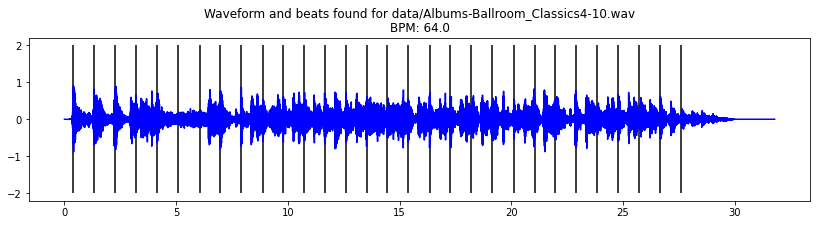

In [12]:
# Just specify the right directory and this code will pick a random file to analyse from within that directory.
#soundFiles = []
#for entry in os.scandir('FILL_IN_YOUR_DATA_DIRECTORY'):
#    if entry.path[-4:] == '.wav':
#        soundFiles += [entry.path]
#fileName = soundFiles[randrange(len(soundFiles))]

# Alternatively specify a file you want to be tested.
fileName = 'data/Albums-Ballroom_Classics4-10.wav'

TestOneFile(fileName, numOfODFs=1, clusterWidth=3, alpha=0.2, innerErrorThreshold=3, outerErrorThreshold=6)

# Testing all files

Below is the code that was used to perform a grid search over the parameter space on multiple different files.

In [ ]:
### GRID SEARCH ###

#Variables used in calculating the score of an agent.
gHitScores = [1, 3, 5, 10, 20, 40]
gMissScores = [0, 1, 3, 5, 10]
gSalienceScores = [0, 1, 3, 5, 10]
gErrorScores = [0, 0.0001, 0.001, 0.01, 0.1, 1]

def TestAll(soundFiles, numOfODFs=1, clusterWidth=3, alpha=0.5, innerErrorThreshold=4, outerErrorThreshold=6):
    """Perform beat tracking on test files, performing a grid search to find the best performing scoring parameters
        soundFiles: List of file paths to be tested
        numOfODFs: How many ODFs to use in finding onsets
        clusterWidth: size of clusters in clustering algorithm
        alpha: Controls momentum vs reactiveness of the beat tracking agents. 0 = momentum only. 1 = reactive only.
        innerErrorThreshold: The window either side of an agents prediction that it will accept
                                an onset as part of the beat
        outerErrorThreshold: The outer window either side of an agents prediction where an onset will affect
                                the agent's period."""
    number_of_sound_files = len(soundFiles)
    
    #Sum the scores in each grid point.
    total_f_measure = np.zeros((len(gHitScores),len(gMissScores),len(gSalienceScores),len(gErrorScores)))
    total_accuracy = np.zeros((len(gHitScores),len(gMissScores),len(gSalienceScores),len(gErrorScores)))
    total_period_error = np.zeros((len(gHitScores),len(gMissScores),len(gSalienceScores),len(gErrorScores)))
    
    #Test a random new file each time.
    numberOfFilesTested = 0
    for i in range(number_of_sound_files):
        print('Number of files tested:', i)
        fileName = soundFiles[random.randint(0,len(soundFiles)-1)]
        #if numberOfFilesTested > 1:
            #Included to speed up testing times
        #    break
        peaksForOneFile = getOnsetsForOneFile(fileName, numOfODFs, plot=False)
        if len(peaksForOneFile) == 0:
            print('Skipping', fileName, 'as no peaks were found.')
        else:
            clusters = calculateClusters(peaksForOneFile, clusterWidth, plot=0)

            #Find the ordered set of onset times.
            uniqueOnsets = sorted(set(peaksForOneFile))

            numberOfStartingOnsets = 15 #Number of agents is numberOfStartingOnsets x numberOfClusters

            agents = letAgentsLoose(clusters, numberOfStartingOnsets, uniqueOnsets,
                                    alpha, innerErrorThreshold, outerErrorThreshold)

            if len(agents)==0:
                print('Skipping', fileName, 'As onsets found (', len(uniqueOnsets), ') but no agents created.')
            else:
                numberOfFilesTested += 1
                #Load ground-truth annotations, and trim before 5 seconds
                annotations = mir_eval.beat.trim_beats(np.array(getAnnotationsFromFile(fileName[:-4] + '.beats')), min_beat_time=5.0)
                #Greedy search over different possible scoring metrics.
                #Return f score and accuracy for all of them, then return the highest scoring one.
                for hitNum,hitScore in enumerate(gHitScores):
                    for missNum,missScore in enumerate(gMissScores):
                        for salienceNum,salienceScore in enumerate(gSalienceScores):
                            for errorNum,errorScore in enumerate(gErrorScores):
                                scoreMatrix = [hitScore, missScore, salienceScore, errorScore]
                                bestAgent = getBestAgent(agents.copy(), scoreMatrix)
                                bestAgentBeatTimes = np.zeros(len(bestAgent.beatTimes))
                                for i,beat in enumerate(bestAgent.beatTimes):
                                    bestAgentBeatTimes[i] = beat/100
                                #Trim before 5 seconds
                                bestAgentBeatTimes = mir_eval.beat.trim_beats(bestAgentBeatTimes, min_beat_time=5.0)
                                
                                #Calculate the average error in the period.
                                bestAgentAveragePeriod = bestAgent.getAveragePeriod()
                                actualPeriod = (annotations[-1:]-annotations[0])/len(annotations)
                                periodError = np.abs(bestAgentAveragePeriod - actualPeriod)/bestAgentAveragePeriod
                                
                                #Calculate f-score
                                f_measure = mir_eval.beat.f_measure(annotations, bestAgentBeatTimes, f_measure_threshold=0.1)
                                #Calculate accuracy at any level
                                CMLc, CMLt, AMLc, AMLt = mir_eval.beat.continuity(annotations, bestAgentBeatTimes)
                                total_f_measure[hitNum][missNum][salienceNum][errorNum] += f_measure
                                total_accuracy[hitNum][missNum][salienceNum][errorNum] += AMLt
                                total_period_error[hitNum][missNum][salienceNum][errorNum] += periodError
        soundFiles.remove(fileName)
    
    
    f_measure = total_f_measure/(numberOfFilesTested)
    accuracy = total_accuracy/(numberOfFilesTested)
    period_error = total_period_error/numberOfFilesTested
    indexOfMaxScore = np.unravel_index(f_measure.argmax(), f_measure.shape)
    
    period_error_for_best_f_score = period_error[indexOfMaxScore[0]][indexOfMaxScore[1]][indexOfMaxScore[2]][indexOfMaxScore[3]]
    accuracy_for_best_f_score = accuracy[indexOfMaxScore[0]][indexOfMaxScore[1]][indexOfMaxScore[2]][indexOfMaxScore[3]]
    return (np.max(f_measure),
            gHitScores[indexOfMaxScore[0]], gMissScores[indexOfMaxScore[1]], gSalienceScores[indexOfMaxScore[2]], gErrorScores[indexOfMaxScore[3]],
            accuracy_for_best_f_score,
            period_error_for_best_f_score)

In [ ]:
from time import time
start_time = time()
possibleAlphas = [0.2]
possibleInnerThresholds = [3]
possibleOuterThresholds = [6]
possibleNumOfODFs = [1]
for a in possibleAlphas:
    for it in possibleInnerThresholds:
        for ot in possibleOuterThresholds:
            if ot >= it:
                soundFiles = []
                for entry in os.scandir('data/AllBallroomData.nosync'):
                    if entry.path[-4:] == '.wav':
                        soundFiles += [entry.path]
                F, fHit, fMis, fSal, fErr, A, pErr = TestAll(soundFiles, numOfODFs=1, clusterWidth=3, alpha=a, innerErrorThreshold=it, outerErrorThreshold=ot)
                print(F, fHit, fMis, fSal, fErr, A, pErr, a, it, ot)

elapsed_time = time() - start_time
print(elapsed_time)